# Test Models

This notebook tests deep learning models for enhanced JPEG reconstruction.

In [1]:
%matplotlib inline
from __future__ import print_function, division
import matplotlib.pylab as plt
import numpy as np
from keras.optimizers import Adam
import os
import glob
import io
from PIL import Image
import sys

from tensorflow.spectral import dct, idct
from scipy.fftpack import dct as DCT, idct as IDCT
from tensorflow.keras.backend import eval
import skimage.measure as metrics

# Importing our U-Net model
MY_UTILS_PATH = "../Modules/"
if not MY_UTILS_PATH in sys.path:
    sys.path.append(MY_UTILS_PATH)
from models import unet_old, unet, my_unet
from cs_models import deep_cascade_unet_no_dc
from metrics import calculate_metrics

Using TensorFlow backend.


In [2]:
def dct2d(im):
    return DCT(DCT(im,type=2,axis=0,norm='ortho'),type=2,axis=1,norm='ortho')
def idct2d(mat):
    return IDCT(IDCT(mat,type=2,axis=0,norm='ortho'),type=2,axis=1,norm='ortho')

def dct_in_blocks(im, block_size = 8):

    rows, cols = im.shape[0], im.shape[1]

    # block size: 8x8
    if rows % block_size == cols % block_size == 0:
        blocks_count = rows // block_size * cols // block_size
    else:
        raise ValueError(("the width and height of the image "
                          "should both be mutiples of %block_size"))

    dct_matrix = np.zeros((rows, cols))

    for i in range(0, rows, block_size):
        for j in range(0, cols, block_size):

            block = im[i:i+block_size, j:j+block_size]
            dct_matrix[i:i+block_size,j:j+block_size] = dct2d(block)

    return dct_matrix

def idct_in_blocks(dct_mat, block_size = 8):

    rows, cols = dct_mat.shape[0], dct_mat.shape[1]

    # block size: 8x8
    if rows % block_size == cols % block_size == 0:
        blocks_count = rows // block_size * cols // block_size
    else:
        raise ValueError(("the width and height of the image "
                          "should both be mutiples of %block_size"))

    im_matrix = np.zeros((rows, cols))

    for i in range(0, rows, block_size):
        for j in range(0, cols, block_size):

            block = dct_mat[i:i+block_size, j:j+block_size]
            im_matrix[i:i+block_size,j:j+block_size] = idct2d(block)

    return im_matrix


In [3]:
# Train and validation data paths
test_path = "../../Gray/*.tif"

# Listing train and validation images
images = glob.glob(test_path)
test_images = images[45000:]

# Summary of images
print("Test set size:", len(test_images))

Test set size: 3624


In [4]:
H,W = 256, 256
norm = 255.0
compr_range = (10,20)

test_unc = np.zeros((len(test_images),H,W,1), dtype=np.float32)
test_compr = test_unc.copy()

dct_test_unc = test_unc.copy()
dct_test_compr = test_unc.copy()

compr_test = np.random.choice(np.arange(compr_range[0],compr_range[1], dtype=int), \
                               len(test_images),replace = True)

# Test set
for ii in range(len(test_images)):
    # Load uncompressed image
    im1 = Image.open(test_images[ii])
    test_unc[ii,:,:,0] = np.array(im1, dtype=np.float32)

    # JPEG compress the image    
    buf = io.BytesIO()
    im1.save(buf, "JPEG", quality=int(compr_test[ii]))
    im2 = Image.open(buf)
    test_compr[ii,:,:,0] = np.array(im2, dtype=np.float32)

test_unc -= 128.0
test_compr -= 128.0

test_unc /= 128.0
test_compr /= 128.0

In [5]:
useBlocks = True

if useBlocks:
    for ii in range(len(test_images)):
        dct_test_compr[ii,:,:,0] = dct_in_blocks(test_compr[ii,:,:,0])
else:
    for ii in range(len(test_images)):
        dct_test_compr[ii,:,:,0] = dct2d(test_compr[ii,:,:,0])
    
# # keep min/max values to de-normalize later
# dct_test_compr_min = np.zeros(len(test_images))
# dct_test_compr_max = np.zeros(len(test_images))

# for ii in range(len(test_images)):
#     dct_test_compr_min[ii] = np.min(dct_test_compr[ii,:,:,0])
#     dct_test_compr_max[ii] = np.max(dct_test_compr[ii,:,:,0])

# print(dct_test_compr_min.shape)
# print(dct_test_compr_max.shape)

In [7]:
opt=Adam(lr=0.001)

#model_name = "../Models/residual_unet_DCT_data_augmentation_compress_10_20-imagenet.hdf5"
model_name = "../Models/residual_wnet_pydct_data_augmentation_compress_10_20-imagenet.hdf5"

#model = unet_old(input_size = (256 ,256 ,1),drop = 0.0,residual = True)
#model=my_unet()
model = deep_cascade_unet_no_dc(depth_str='ii')

model.compile(loss = "mse",optimizer=opt)

model.load_weights(model_name)

0 i
Append U-net block
1 i
Append U-net block


In [8]:
pred = model.predict(dct_test_compr)

In [9]:
img_pred = test_unc.copy()

test_unc *= 128.0
test_unc += 128.0

test_compr *= 128.0
test_compr += 128.0

In [10]:
if useBlocks:
    for ii in range(len(test_images)):
        img_pred[ii,:,:,0] = idct_in_blocks(pred[ii,:,:,0])
else:
    for ii in range(len(test_images)):
        img_pred[ii,:,:,0] = idct2d(pred[ii,:,:,0])
        
img_pred *= 128.0
img_pred += 128.0

0.0 254.0
0.55903625 268.0655


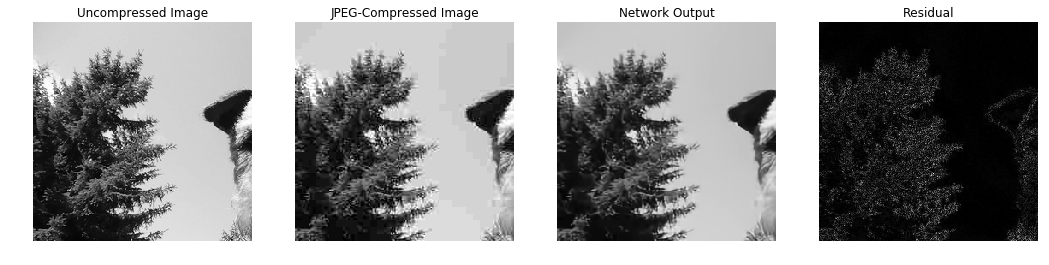

In [11]:
#print(pred)

slc = 65

print(np.min(test_unc[slc,:,:,0]), np.max(test_unc[slc,:,:,0]))
print(np.min(img_pred[slc,:,:,0]),np.max(img_pred[slc,:,:,0]))

# plt.figure(figsize = (9,18))
# plt.subplot(3,1,1)
# plt.axis("off")
# plt.title("Uncompressed Image", fontsize=24)
# plt.imshow(dct_test_unc[slc,:,:,0],cmap = "gray")
# plt.subplot(3,1,2)
# plt.axis("off")
# plt.title("Network Output", fontsize=24)
# plt.imshow(pred[slc,:,:,0],cmap = "gray")
# plt.subplot(3,1,3)
# plt.axis("off")
# plt.title("Residual", fontsize=24)
# plt.imshow((dct_test_unc[slc,:,:,0] - img_pred[slc,:,:,0]),cmap = "gray")
# plt.show()

plt.figure(figsize = (18,12))
plt.subplot(1,4,1)
plt.axis("off")
plt.title("Uncompressed Image")
plt.imshow(test_unc[slc,:,:,0],cmap = "gray")
plt.subplot(1,4,2)
plt.axis("off")
plt.title("JPEG-Compressed Image")
plt.imshow(test_compr[slc,:,:,0],cmap = "gray")
plt.subplot(1,4,3)
plt.axis("off")
plt.title("Network Output")
plt.imshow(img_pred[slc,:,:,0],cmap = "gray")
plt.subplot(1,4,4)
plt.axis("off")
plt.title("Residual")
plt.imshow(abs(test_unc[slc,:,:,0] - img_pred[slc,:,:,0]),cmap = "gray")
plt.show()

Test set results
0.0 249.0
-0.4797058 233.82066
0.0 255.0
1.7185745 252.59761
0.0 235.0
-7.548584 241.48059


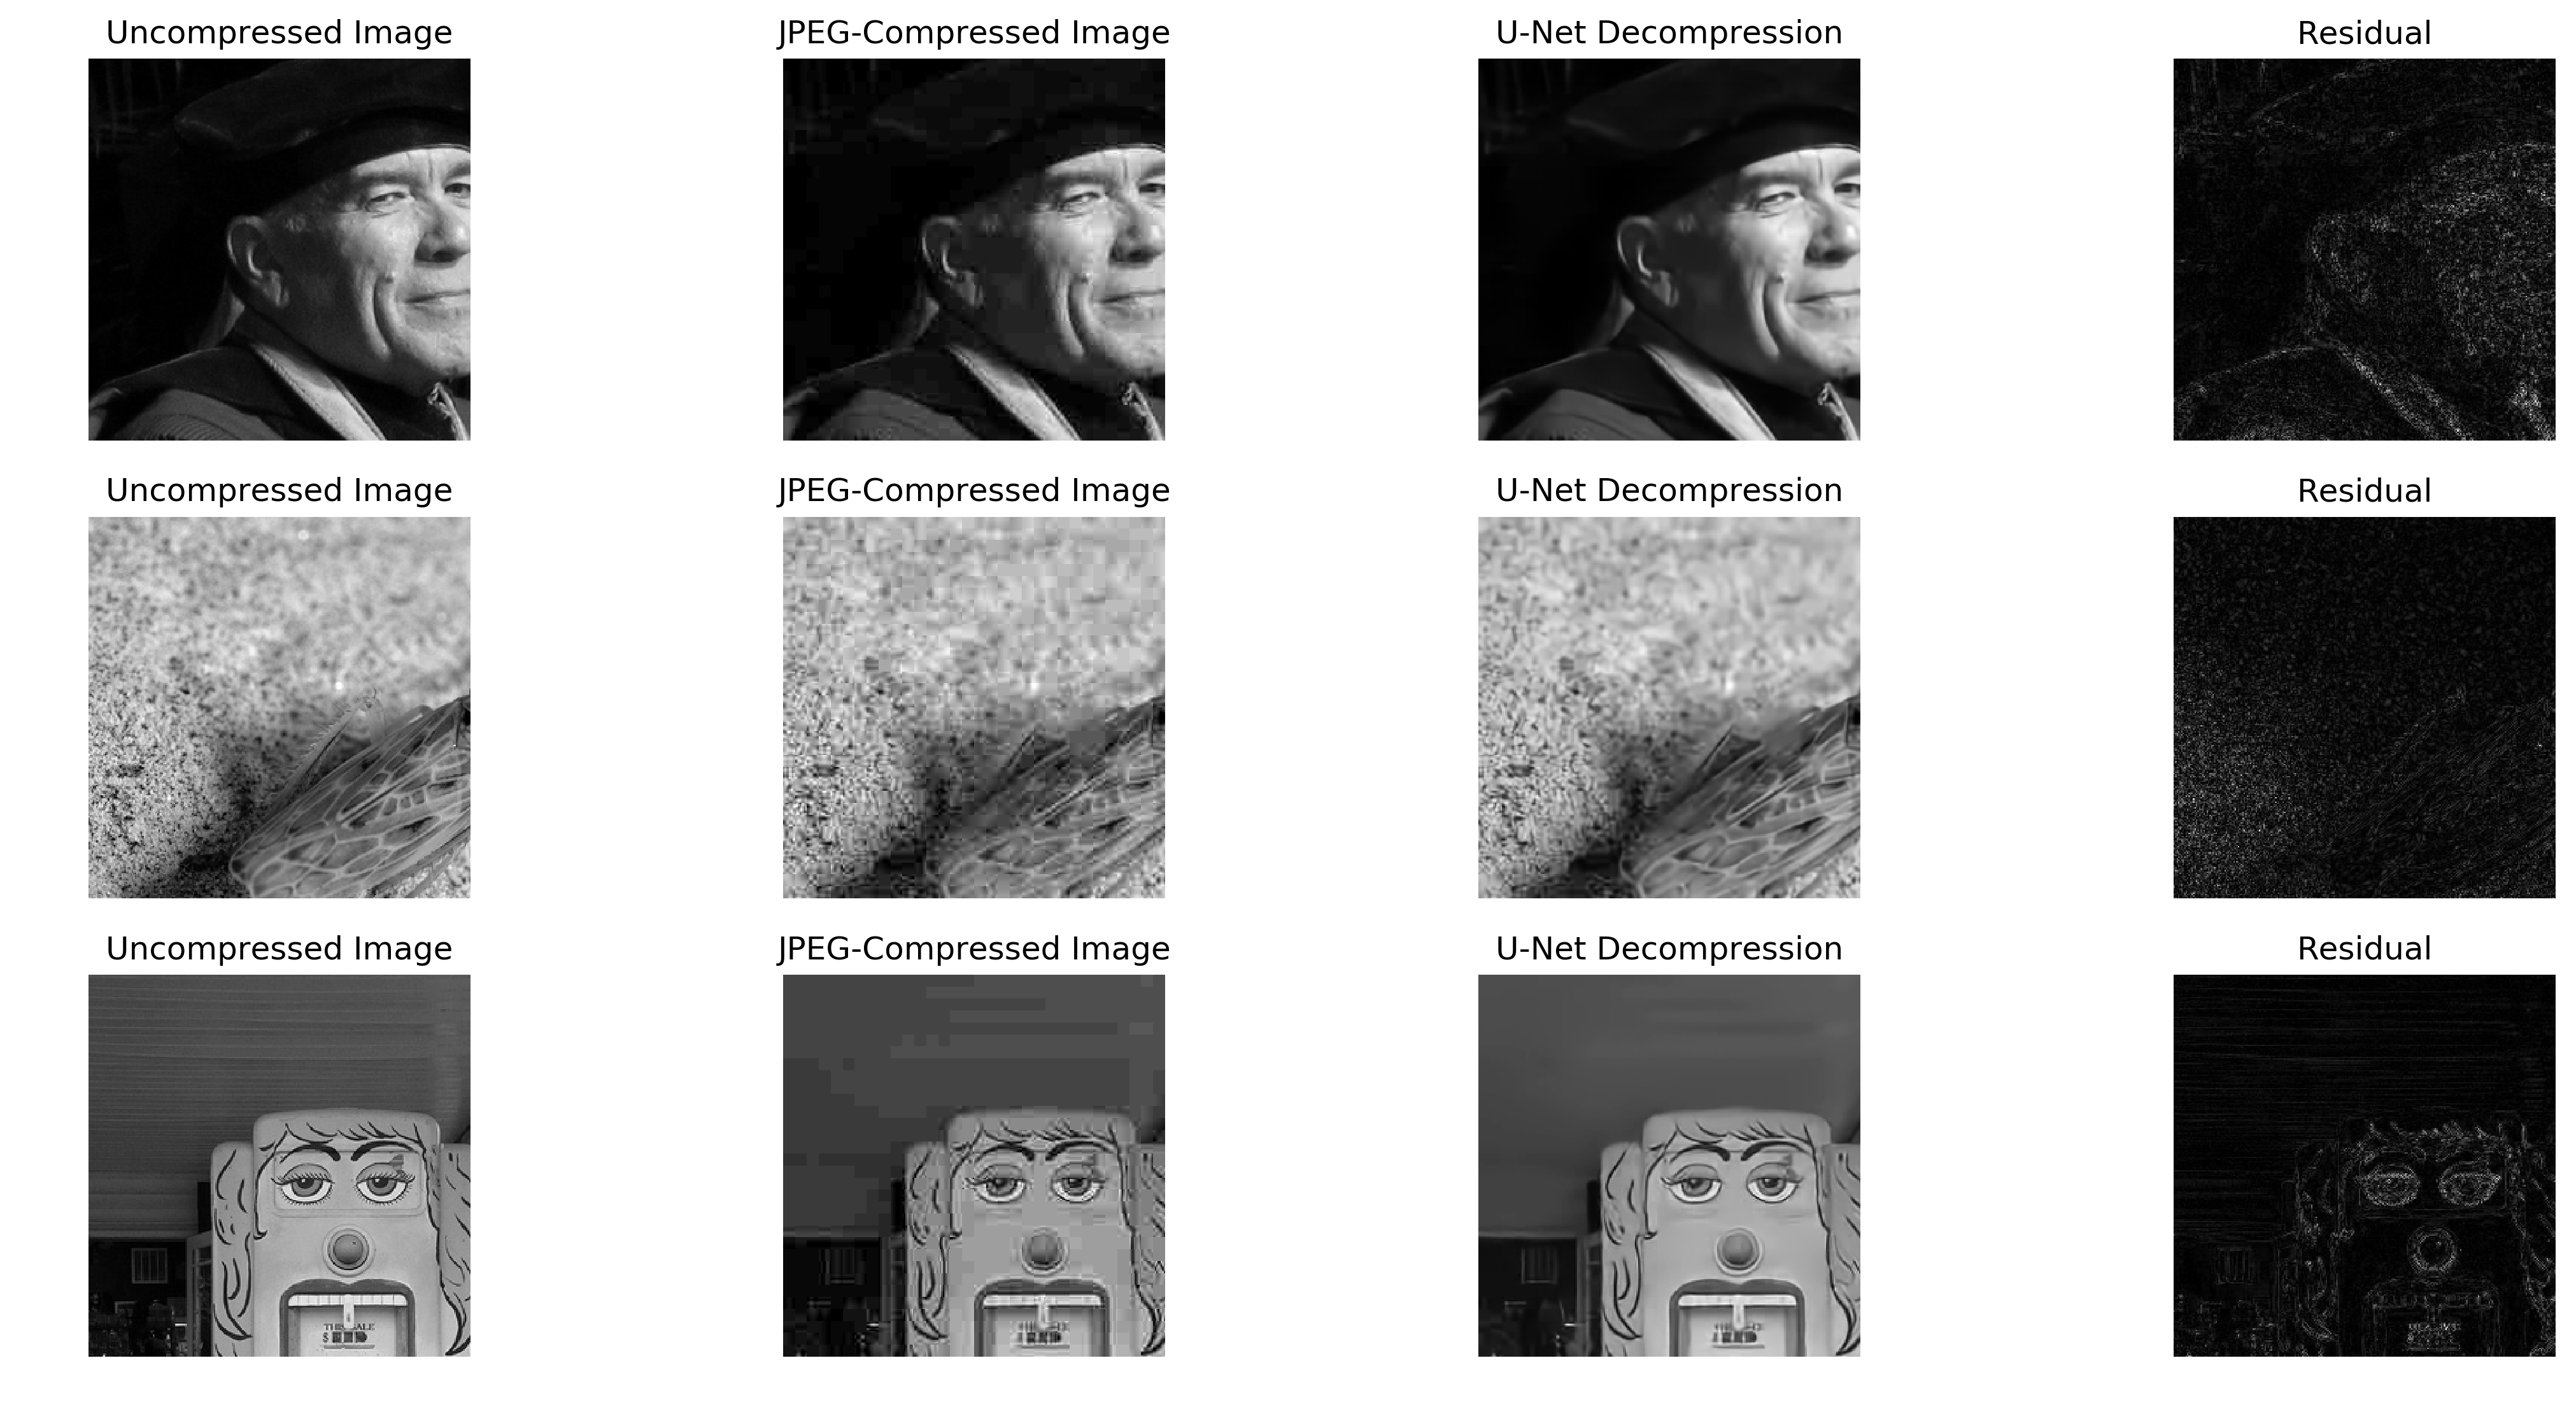

In [12]:
indexes_test = np.arange(len(pred),dtype = int)
np.random.shuffle(indexes_test)
indexes_test = indexes_test[:3]

print("Test set results")
plt.figure(figsize = (18,9),dpi = 300)
for ii in range(3):
    print(np.min(test_unc[indexes_test[ii],:,:,0]),np.max(test_unc[indexes_test[ii],:,:,0]))
    print(np.min(img_pred[indexes_test[ii],:,:,0]),np.max(img_pred[indexes_test[ii],:,:,0]))

    plt.subplot(3,4,4*ii+1)
    plt.imshow(test_unc[indexes_test[ii],:,:,0],cmap = "gray")
    plt.axis("off")
    plt.title("Uncompressed Image")
    plt.subplot(3,4,4*ii+2)
    plt.imshow(test_compr[indexes_test[ii],:,:,0],cmap = "gray")
    plt.axis("off")
    plt.title("JPEG-Compressed Image")
    plt.subplot(3,4,4*ii+3)
    plt.imshow(img_pred[indexes_test[ii],:,:,0],cmap = "gray")
    plt.axis("off")
    plt.title("U-Net Decompression")
    plt.subplot(3,4,4*ii+4)
    plt.imshow(abs(test_unc[indexes_test[ii],:,:,0] - img_pred[indexes_test[ii],:,:,0]),cmap = "gray")
    plt.axis("off")
    plt.title("Residual")
plt.show()     

# Performance Metrics

In [13]:
metr = calculate_metrics(test_unc, test_compr, img_pred)

(3624, 3, 2)


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/util/arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]


(3624, 3, 2)

JPEG-Compressed Metrics
SSIM: 0.811 +/- 0.082
PSNR: 28.110 +/- 3.606
NRMSE: 4.304 +/- 1.777


Network Metrics
SSIM: 0.849 +/- 0.089
PSNR: 29.806 +/- 3.857
NRMSE: 3.686 +/- 1.705


In [12]:
metr = np.zeros((len(pred),3,2),dtype=np.float32)
print(metr.shape)

count = 0
for ii in range(len(pred)): 
    
    # Check if the metric values are finite
    # JPEG-Compressed Metrics
    a = metrics.compare_ssim(test_unc[ii,:,:,0],test_compr[ii,:,:,0])
    if ~np.isfinite(a):
        print("removing %i SSIM from JPEG list." %ii)
        count += 1
        continue
        
    b = metrics.compare_psnr(test_unc[ii,:,:,0],test_compr[ii,:,:,0],\
                                        data_range=(test_compr[ii,:,:,0].max()-test_compr[ii,:,:,0].min()))
    if ~np.isfinite(b):
        print("removing %i PSNR from JPEG list." %ii)
        count += 1
        continue
        
    c = metrics.compare_nrmse(test_unc[ii,:,:,0],test_compr[ii,:,:,0],'min-max') *100.0
    if ~np.isfinite(c):
        print("removing %i NRMSE from JPEG list." %ii)
        count += 1
        continue

    # Network metrics
    d = metrics.compare_ssim(test_unc[ii,:,:,0],img_pred[ii,:,:,0])
    if ~np.isfinite(d):
        print("removing %i SSIM from network list." %ii)
        count += 1
        continue
        
    e = metrics.compare_psnr(test_unc[ii,:,:,0],img_pred[ii,:,:,0],\
                                       data_range=(img_pred[ii,:,:,0].max()-img_pred[ii,:,:,0].min()))
    if ~np.isfinite(e):
        print("removing %i PSNR from network list." %ii)
        count += 1
        continue
        
    f = metrics.compare_nrmse(test_unc[ii,:,:,0],img_pred[ii,:,:,0],'min-max') *100.0
    if ~np.isfinite(f):
        print("removing %i NRMSE from network list." %ii)
        count += 1
        continue
    
    metr[ii,0,0] = a
    metr[ii,1,0] = b
    metr[ii,2,0] = c
    metr[ii,0,1] = d
    metr[ii,1,1] = e    
    metr[ii,2,1] = f
    
# remove empty rows
metr = np.delete(metr,range(len(metr)-count, len(metr)),axis=0)
print(metr.shape)
    
#     # JPEG-Compressed Metrics
#     metr[ii,0,0] = metrics.compare_ssim(test_unc[ii,:,:,0],test_compr[ii,:,:,0])
#     metr[ii,1,0] = metrics.compare_psnr(test_unc[ii,:,:,0],test_compr[ii,:,:,0],\
#                                         data_range=(test_compr[ii,:,:,0].max()-test_compr[ii,:,:,0].min()))
#     metr[ii,2,0] = metrics.compare_nrmse(test_unc[ii,:,:,0],test_compr[ii,:,:,0],'min-max') *100.0
    
#     # Network Metrics
#     metr[ii,0,1] = metrics.compare_ssim(test_unc[ii,:,:,0],pred[ii,:,:,0])
#     metr[ii,1,1] = metrics.compare_psnr(test_unc[ii,:,:,0],pred[ii,:,:,0],\
#                                        data_range=(pred[ii,:,:,0].max()-pred[ii,:,:,0].min()))
#     metr[ii,2,1] = metrics.compare_nrmse(test_unc[ii,:,:,0],pred[ii,:,:,0],'min-max') *100.0
    
print("\nJPEG-Compressed Metrics")
print("SSIM: %.3f +/- %.3f" %(metr[:,0,0].mean(),metr[:,0,0].std()))
print("PSNR: %.3f +/- %.3f" %(metr[:,1,0].mean(),metr[:,1,0].std()))
print("NRMSE: %.3f +/- %.3f" %(metr[:,2,0].mean(),metr[:,2,0].std()))
print('\n')
print("Network Metrics")
print("SSIM: %.3f +/- %.3f" %(metr[:,0,1].mean(),metr[:,0,1].std()))
print("PSNR: %.3f +/- %.3f" %(metr[:,1,1].mean(),metr[:,1,1].std()))
print("NRMSE: %.3f +/- %.3f" %(metr[:,2,1].mean(),metr[:,2,1].std()))

(3624, 3, 2)


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/util/arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/measure/simple_metrics.py:142: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10((data_range ** 2) / err)


removing 310 PSNR from JPEG list.
(3623, 3, 2)

JPEG-Compressed Metrics
SSIM: 0.551 +/- 0.171
PSNR: 28.128 +/- 3.634
NRMSE: 4.299 +/- 1.803


Network Metrics
SSIM: 0.590 +/- 0.161
PSNR: 29.839 +/- 3.853
NRMSE: 3.699 +/- 1.722


In [71]:
print(np.min(test_unc), np.max(test_unc))
print(np.min(test_compr), np.max(test_compr))
print(np.min(img_pred), np.max(img_pred))

0.0 255.0
0.0 255.0
-50.867065 309.4737


In [49]:
# test1 = metrics.compare_nrmse(test_unc[2787,:,:,0],test_compr[2787,:,:,0],'min-max') *100.0
# test2 = metrics.compare_nrmse(test_unc[2787,:,:,0],img_pred[2787,:,:,0],'min-max') *100.0

# print(test1)
# print(test2)

for ii in range(len(pred)):
    print(ii, metr[ii, 2,0],metr[ii,2,1])

0 3.8648405 3.0271885
1 3.8666792 3.3789058
2 2.9603302 2.513371
3 2.8226085 2.3690133
4 2.6992545 2.3734505
5 1.7522887 1.3885703
6 3.133575 2.563363
7 3.4908829 3.080164
8 4.686284 4.1865506
9 2.2427952 2.0504475
10 2.0405636 1.572605
11 2.4332838 1.7977618
12 2.1900172 1.9913993
13 6.933885 6.6628804
14 6.658289 6.1616406
15 3.5489378 3.0911074
16 1.7422012 1.0851688
17 3.8233528 3.4031692
18 2.7734897 2.118223
19 4.6864285 3.9825974
20 2.7470796 2.3737652
21 4.009761 3.602947
22 4.935338 4.283215
23 6.039496 5.6047163
24 2.6799376 2.2641687
25 2.604374 2.4117754
26 6.6304445 6.1597414
27 3.6728194 2.999551
28 2.5915775 2.2474844
29 3.7721467 2.9590592
30 2.5222316 2.1220665
31 6.971919 6.346447
32 4.6410985 4.161196
33 4.0635805 2.9724426
34 4.7742953 3.9221172
35 3.4319012 2.6465473
36 2.3003438 2.0607505
37 2.8301802 2.3226206
38 2.500525 2.0846016
39 3.5485394 2.776656
40 3.2294588 2.4991233
41 4.900813 4.5496206
42 2.2906075 1.9112386
43 6.322613 5.5859723
44 2.9944887 2.558282

867 4.4405937 3.9500382
868 3.9942439 3.251257
869 3.6121283 3.0169263
870 4.378091 3.9639342
871 5.5813236 5.1727743
872 1.8345376 1.5320644
873 2.83383 2.4486194
874 3.3261964 3.1112003
875 3.8060987 3.4913876
876 3.8277762 3.0441425
877 4.6848555 4.1560163
878 2.2529135 1.6658973
879 4.276083 3.6433651
880 4.7782345 4.1753197
881 7.927113 6.973991
882 2.402381 2.0735757
883 7.8260007 7.032918
884 1.0156896 0.71795213
885 2.3763845 1.9137303
886 3.7162476 2.794403
887 4.287656 3.844229
888 2.6042795 2.288831
889 4.3412113 3.3941598
890 3.602492 3.0208228
891 3.4448256 2.8430626
892 3.8519697 3.1353405
893 2.8135724 2.242257
894 5.8075237 4.950401
895 2.6168458 2.0492904
896 2.4800768 2.0596597
897 4.2072144 3.4715822
898 2.8725524 2.4789197
899 6.250518 5.4218807
900 4.358905 4.049781
901 2.8563273 2.2045336
902 4.0029116 3.5750878
903 3.1395848 2.6671724
904 4.858078 4.259316
905 1.9147371 1.3687212
906 6.7451763 5.850613
907 2.4918795 2.1501396
908 2.8948746 2.6708603
909 4.106228 

1527 4.577389 3.9322054
1528 5.184944 3.7261705
1529 3.0751448 2.6741645
1530 2.4490256 2.1639225
1531 5.102438 4.606307
1532 5.461777 4.4458694
1533 5.1427345 4.5729194
1534 1.5881757 1.1321568
1535 2.9304845 2.3146844
1536 7.647026 7.1639094
1537 6.442897 5.959162
1538 1.6627089 1.3977529
1539 7.055714 6.3638554
1540 4.2014546 3.5006976
1541 3.6631935 3.3076775
1542 1.5260186 1.244583
1543 2.9417481 2.4870307
1544 3.15919 2.4465575
1545 6.456694 5.6519184
1546 11.175125 10.3797035
1547 3.4095223 2.9345586
1548 5.0802736 4.6165237
1549 6.894376 6.3198934
1550 2.6249404 1.9364184
1551 4.147494 3.6077504
1552 3.6180205 3.0879874
1553 3.287949 2.5430553
1554 2.8335412 2.3720055
1555 2.6071389 2.231254
1556 5.6506133 5.0111227
1557 3.08033 2.5209634
1558 1.392447 1.2216392
1559 4.3730607 4.126668
1560 2.6261446 2.2553344
1561 2.873757 2.426343
1562 3.755928 3.4529238
1563 4.648349 4.322863
1564 2.127889 1.828038
1565 7.094811 6.4234924
1566 4.0279894 3.7582052
1567 2.7024603 2.281494
1568

2160 3.4030719 2.851354
2161 2.233921 1.8014336
2162 2.670278 2.341566
2163 1.90692 1.5624343
2164 4.5325294 3.7193391
2165 3.8006113 3.08309
2166 3.752477 3.1001492
2167 1.496758 1.1427548
2168 6.2581196 5.469735
2169 4.463961 3.8767023
2170 3.0300484 2.794718
2171 2.5250988 1.937745
2172 6.694405 5.943115
2173 1.9057955 1.4726516
2174 5.856485 5.374678
2175 6.8377604 6.247295
2176 6.2755814 5.8251843
2177 4.0200777 3.421847
2178 4.642596 4.2550573
2179 3.7325792 2.871918
2180 3.2460358 2.7088344
2181 3.445643 2.9070745
2182 2.504669 2.2019987
2183 3.1295342 2.5008123
2184 4.8563094 4.7455053
2185 2.4204357 1.8747547
2186 5.1982403 4.9038787
2187 5.0303054 4.387506
2188 3.1252584 2.669685
2189 4.5812974 4.2464213
2190 5.177957 4.554153
2191 2.7794476 2.2708347
2192 5.6036544 5.033028
2193 5.31165 5.0575566
2194 3.3408546 2.8102105
2195 3.9919684 3.1667256
2196 4.5406995 4.2405977
2197 4.104052 3.5389042
2198 1.7808765 1.3743656
2199 4.252732 3.7742643
2200 2.7285702 2.4910212
2201 5.8

2801 2.1149528 1.681508
2802 3.9730597 3.4904983
2803 5.553896 5.1033087
2804 2.3604984 2.0555012
2805 5.845701 5.429039
2806 12.181755 8.214832
2807 8.165245 7.1462035
2808 1.6494571 1.3525928
2809 2.835333 2.376456
2810 3.2652948 2.6786718
2811 3.1373324 2.7413583
2812 6.865591 6.2270145
2813 7.2005787 6.1879697
2814 3.5223255 2.9478254
2815 2.6909716 2.0987835
2816 4.7197113 4.126669
2817 5.339937 4.9560657
2818 8.112401 7.0260496
2819 5.19713 4.5988636
2820 5.293176 4.900105
2821 3.5281842 3.0239604
2822 7.6522913 7.1375346
2823 3.217343 2.616461
2824 2.9850283 2.514505
2825 5.858647 4.800307
2826 7.1751747 6.6872067
2827 3.6161401 3.1784165
2828 2.6928792 1.8937508
2829 2.3742294 2.1393971
2830 3.000946 2.5661936
2831 2.843091 2.2474654
2832 2.6917667 2.2794511
2833 3.2107096 2.9314961
2834 4.3738246 3.6812186
2835 2.9412224 2.4938033
2836 2.1098888 1.6777492
2837 1.4100108 1.0764741
2838 9.042444 8.217856
2839 5.9138017 5.4713573
2840 7.7007356 6.878775
2841 2.653127 2.2635832
28

3507 3.8708797 2.6709387
3508 4.892906 3.9256043
3509 3.6063814 3.2318904
3510 3.9881275 2.9532108
3511 1.72034 1.3068151
3512 7.867351 7.4209456
3513 2.8692791 2.1116693
3514 4.8707366 4.5151105
3515 2.7855663 2.4090226
3516 3.3300917 2.8837605
3517 2.7026453 1.8556613
3518 2.6655178 2.2197773
3519 6.765359 6.3334055
3520 2.5152524 2.1254559
3521 3.2061598 2.7839282
3522 3.0622647 2.6091104
3523 3.351668 2.8519115
3524 3.277076 2.6672962
3525 7.1295786 6.397614
3526 2.9398587 2.4751444
3527 4.064213 3.3663464
3528 3.1672316 2.707949
3529 2.8538287 2.1167874
3530 4.4555464 3.7592254
3531 5.328145 4.5452795
3532 3.341718 2.957425
3533 2.8819704 2.4380248
3534 3.1202135 2.2343333
3535 3.2186975 2.806845
3536 1.8876182 1.230518
3537 3.0789182 2.5937707
3538 2.3014815 1.9120889
3539 3.5326931 2.8379033
3540 4.0129967 3.4086409
3541 2.9546814 2.4809484
3542 4.0339694 3.6745615
3543 5.709502 4.986264
3544 2.9200668 2.47483
3545 3.856402 3.260212
3546 4.0091953 3.4099445
3547 3.6119742 2.7094

IndexError: index 3600 is out of bounds for axis 0 with size 3600

In [74]:
for ii in range(len(pred)):
    test1 = metrics.compare_psnr(test_unc[ii,:,:,0],test_compr[ii,:,:,0],\
                                       data_range=(test_compr[ii,:,:,0].max()-test_compr[ii,:,:,0].min()))
    test2 = metrics.compare_psnr(test_unc[ii,:,:,0],img_pred[ii,:,:,0],\
                                       data_range=(img_pred[ii,:,:,0].max()-img_pred[ii,:,:,0].min()))
    print(ii, test1,test2)


0 28.658948486982524 30.802383117784444
1 28.432639815222384 29.970546059966466
2 31.131411416239168 32.637302799325795
3 31.626425745270158 33.06770257949196
4 30.972780344404054 32.153652312421656
5 35.74565688072112 37.008907858247035
6 29.72072654697567 31.684545870163184
7 29.6363078536339 30.95040694696941
8 26.72504050770925 27.988145738681503
9 32.27304221101096 32.96077466813571
10 33.83912667897285 36.14626194705024
11 33.20127943412648 36.756192197306476
12 33.677810080114604 33.767901119695615
13 23.765741053728583 24.19206143858154
14 23.601140376111424 24.46978905089523
15 29.160022153965283 29.596892588738474
16 35.4525897503088 40.28584550208208
17 28.524965721323376 29.502764320748906
18 31.371013599574447 33.745719278636926
19 26.578901417749996 27.53560111804824
20 30.912794889496222 32.07848758243253
21 29.630919771369342 29.428282773417802
22 26.414614667081253 27.07419855668071
23 24.44837950225628 24.67360811749604
24 31.30139914577606 32.41374447578479
25 32.105

330 25.586652164052847 26.577840210960844
331 28.493049949811898 29.721867056859224
332 26.08570896606635 27.21322026396606
333 28.18189756642342 28.436768940297775
334 27.727569963386614 28.446376700877693
335 22.178087685433766 24.031260359901093
336 37.40360963042827 40.047875684014855
337 25.11104921213516 25.717217034898347
338 27.587901412973196 28.47401174469391
339 29.445144289950086 30.65390634124769
340 27.085341853740665 28.59470790329006
341 31.677767305818403 33.666195871725975
342 31.77354342958017 33.53999859326685
343 24.054128266568174 25.049962944895107
344 25.189677869035204 27.812919417144077
345 27.91842594136307 29.300315076742546
346 32.999498937690674 33.64497367794594
347 36.33250467273144 36.10220736183528
348 29.561582761129035 31.17604818327439
349 28.72322140732158 29.375767121215898
350 29.423337473098318 31.608999226020963
351 29.252087239683327 29.523194352325838
352 23.555837518139484 25.737208984590687
353 28.445007999264817 29.991798850420498
354 23.8

736 28.941511728483242 29.34631949383961
737 29.064002701873402 31.053314190415627
738 32.96764453113568 36.6648052476343
739 26.606114968264407 28.970455575066744
740 27.47967326059228 30.2845262187058
741 27.13040072028201 29.01466473399831
742 32.59580396270271 33.229882214368416
743 32.9485910319988 35.4121962291266
744 28.69250920318523 30.562564942612674
745 35.126501999622896 36.56337572738431
746 31.183735627650414 34.16402710512735
747 24.480617046490668 25.31436860630655
748 24.950410064098584 24.582868157197808
749 27.19852339241932 28.788548131388318
750 27.988964456897335 28.97927218011461
751 32.726850431330156 33.24489173468539
752 29.51471843129674 30.228235484288255
753 25.67337886466777 25.987169266552172
754 27.604902885277028 29.381376224916828
755 36.22445389712287 37.227266377942705
756 27.72039456627143 29.077950931346656
757 31.98203604781847 33.32359029529434
758 31.74722441204991 33.78904318283909
759 27.439105424508355 29.03674508128674
760 30.435816852755355

964 28.73656407631785 32.61729294738328
965 28.996746638185517 30.786211095514435
966 29.05223788780843 31.16265988323804
967 26.739392535493785 28.33525940366036
968 28.11164475456674 30.10085993538896
969 27.76208923858885 29.152270270420864
970 20.47099719416294 19.39515410936256
971 30.112028570731354 31.773618340738
972 27.794217853510744 29.04966605346052
973 31.54061997231882 31.977148642892608
974 31.386168424493977 34.88864962222626
975 30.07936841177556 29.429704716312894
976 28.368395034802724 29.658113019455858
977 26.168113260793596 28.780084431528003
978 30.647230230770045 33.19920918277437
979 22.310263657961368 24.26696517402965
980 25.243514583395896 27.118648506486622
981 25.661188040480937 27.46855872908467
982 32.56065142999553 35.936517332292105
983 29.453678491572877 32.048564843519436
984 30.36530334295557 32.61422015100324
985 26.26619770016758 26.22862945855544
986 39.487690265058276 40.64612504017446
987 24.253548367266433 22.660404538850266
988 29.62064845199

1190 30.827647883348558 31.414523673521817
1191 23.11162428096672 24.165581399586202
1192 31.129942470441936 32.37378107661383
1193 30.714300053856448 33.10389537615742
1194 29.903312927172728 31.559077527542797
1195 24.10010552139282 27.230086331732068
1196 30.25409328148274 32.02733050552218
1197 33.05024607345923 35.4470147667874
1198 24.446173549515876 25.704785985779314
1199 28.43721420045448 31.946943007280556
1200 27.395055311876888 29.85355825385473
1201 24.489256662207197 26.566323173004797
1202 31.083497855536997 32.09041900700936
1203 28.80719142641147 30.611165634851023
1204 35.450165421810844 36.77469679593999
1205 24.476192839357147 26.340507709998022
1206 32.20000450019556 34.548445172194235
1207 32.89706647327317 33.79582144376672
1208 32.78093694409615 34.61913047563679
1209 29.64635270749392 32.88650229267012
1210 23.646016052549584 25.242828338198954
1211 25.90256048836045 28.850274205937172
1212 29.763455579945862 31.58800410331733
1213 28.082531511267916 30.5831879

1417 24.565591186023607 24.867007739607203
1418 24.470436118133158 26.6279608801762
1419 30.04584928552604 31.00237336785968
1420 25.631992884811886 26.472546645663513
1421 26.2553674802571 27.05949502881012
1422 23.039347753707524 24.86894098817549
1423 25.672015656818306 28.26719884675458
1424 32.9284505951689 34.877647999763255
1425 27.296088919177826 27.519704279269078
1426 31.090595617375946 31.994166876496216
1427 28.739636257506575 30.687287710512358
1428 29.364094713131337 31.490583402763164
1429 26.05167280428774 29.340609703491577
1430 35.29325226020493 37.85076710557714
1431 30.020096941863663 31.647036038451503
1432 26.992948572221152 28.79624366404449
1433 28.294632123658783 29.046390766792065
1434 26.836581779840323 27.568093373018577
1435 31.16161417975244 33.33601043509625
1436 33.66367851403933 34.555109778525775
1437 24.46698990633921 25.914320556619238
1438 26.340977522989387 28.015864530903812
1439 24.284637537851715 25.719321737193184
1440 25.288478224030708 27.571

1647 26.065047292066748 26.728206182597418
1648 22.59349740522968 24.008008697857758
1649 29.382567556431994 30.183087615001753
1650 29.61927493871844 31.130445385264306
1651 28.652272882765807 31.222745008472387
1652 28.725093297886165 30.10863600754722
1653 32.060224731497335 32.11638565677252
1654 25.741376207928838 27.035682302337037
1655 31.140863681498434 33.403832371865434
1656 32.49713648233573 35.62138817824865
1657 33.105611005185565 35.735914416873065
1658 30.422762852180067 32.19806829030473
1659 20.099980194951407 22.791924973515563
1660 35.15241579288745 36.02574366989823
1661 27.051143510511586 29.274063642184768
1662 27.30726440208182 28.335331465744254
1663 31.115928310051867 31.34613867476817
1664 34.837050460118576 35.622452934137186
1665 30.11337884076927 33.109333922123305
1666 29.29524750787302 29.842652507755737
1667 32.674260886110176 34.9009953420133
1668 25.03849252089845 27.340609620373428
1669 24.999848456959587 25.232410010276215
1670 30.881689080537896 32.

1876 29.01139543989069 29.711724752581713
1877 29.84702283574744 32.95519832056267
1878 34.21142352989956 35.611327236025716
1879 25.00926101986792 26.111732480622642
1880 22.6723529588795 25.724787223930843
1881 27.54478471980924 29.452491619711903
1882 32.04036504619742 34.39410807514237
1883 23.502317225524074 26.237296706588214
1884 25.50598491972963 26.52607043850473
1885 30.637487267525078 31.626423942795917
1886 26.33886977162545 27.73226034551297
1887 23.52511483681113 24.153682551531585
1888 26.57323746382668 26.739681761306954
1889 28.919341275394753 30.422195487553072
1890 26.05807549415559 28.238870076073056
1891 32.9228976466941 34.94963448807942
1892 25.830072250860333 28.613010393300016
1893 30.739090781055005 31.65176991387291
1894 26.035562243336756 27.551022990155907
1895 33.00962194803865 33.02761356215635
1896 27.58633206878632 29.308353737975033
1897 27.443415410929607 27.234413825202985
1898 31.04705708199318 33.84003715266031
1899 24.96407022574512 25.63644731003

2102 31.391003439916474 33.791594168698175
2103 28.02648237643689 31.061286521250334
2104 26.60171779696771 27.670112517149484
2105 33.303866516808576 34.9282875119487
2106 27.776183143793904 29.579580487764034
2107 33.663708931602386 34.848057862670665
2108 25.175813462077116 26.781677800159038
2109 25.24769860413791 25.149722492261976
2110 31.51058728498117 33.676536736789835
2111 25.854774076774344 28.5200451785839
2112 32.765763314274736 36.452472666872204
2113 27.439867827569753 28.041779499380134
2114 26.843639889633856 28.858137494148608
2115 29.823928592549724 31.17663877813715
2116 27.25096277614473 27.269675701186188
2117 30.293045190216624 31.93823200399068
2118 28.3335318251958 29.954444466058124
2119 20.191373520284106 22.12777866151647
2120 31.36988693051466 32.72159556343537
2121 31.332469123502378 34.27051668746791
2122 32.869309014679715 36.470170681876546
2123 26.30877504432671 28.759138322172294
2124 27.545934250254803 27.918580944667525
2125 24.600909763101953 25.55

2313 30.830088681847165 32.71355808954083
2314 29.56821907882989 30.706363293482255
2315 29.035751192956173 31.209288865601042
2316 29.812704564570645 31.36010716350006
2317 29.888283875405023 31.047950085147782
2318 31.218362299735315 31.411509266710645
2319 27.684014956751 29.845534856206065
2320 22.772927950900154 24.105144718869603
2321 29.543295727195066 30.343849097391264
2322 37.13249611287397 38.023087494881906
2323 33.92051154601472 37.21157179758358
2324 31.56228235252913 34.917160854434044
2325 29.611248904170523 30.981775701655646
2326 26.6298054136765 28.442375412735107
2327 26.2459522016362 27.813521309496743
2328 22.100872413140394 24.4320630259924
2329 33.68774407933432 35.37456064894796
2330 31.436697329994594 31.77232557684985
2331 21.607097960538493 23.480461842051852
2332 26.722678024344113 29.65799352865342
2333 32.21764590038816 32.73942611654174
2334 32.47165212474693 33.64846246430997
2335 26.908509291089274 29.008230719417295
2336 27.871356038440346 30.11552125

2544 26.82653883308876 26.86151285562749
2545 25.709507935991628 26.613331044856274
2546 28.290492083469427 29.71095990781107
2547 22.075744685905477 23.485898692749963
2548 26.0150590456009 29.385487951882556
2549 30.750307930369605 32.70445458493141
2550 30.344472775965706 33.251674305832154
2551 25.799556048858825 25.900631643820834
2552 30.938248596161714 32.03310335663798
2553 24.872853113578877 25.841243567814534
2554 31.651393065941768 32.97297114543839
2555 31.713041851000014 33.475533483500705
2556 24.34342019826829 25.891670957038567
2557 27.59409544800425 29.593989555167518
2558 28.167269192129 30.88120365990879
2559 34.7271768232503 36.37726150676237
2560 25.270296179239118 28.23621535121971
2561 24.27660277754481 25.786469089205667
2562 33.28389607205818 37.32647473807639
2563 24.45366256460884 24.750624171511795
2564 28.07521407784556 28.881765933378475
2565 33.06045837048918 34.67874661192626
2566 27.272428954499283 29.041850897139796
2567 31.525917905255262 33.627310358

2775 22.860842838720696 23.1172460864219
2776 34.47956488855725 35.811282807051974
2777 25.585627157760015 27.057515513327996
2778 29.42194377370874 31.15212222208352
2779 29.61350924362229 31.281848269051522
2780 24.068473831337307 25.806738018964325
2781 29.961861738020836 30.901898017274053
2782 31.168424092224715 31.3150990459225
2783 27.428910627120477 28.534138860350925
2784 30.798567118230523 34.508803955940664
2785 27.633917939997655 30.4341639848769
2786 32.773310651077935 34.35641622984546
2787 29.822425866225977 30.275809394477236
2788 24.69318571130208 26.557666271236776
2789 34.36100357985055 35.82959401615816
2790 26.277819403487108 28.663827738604283
2791 29.42650993509318 30.064768209179785
2792 28.290770530232518 30.01131283704703
2793 28.587190269306344 30.15475687539621
2794 24.084388120063792 26.20638745881008
2795 34.44770942565502 36.989548780281005
2796 24.873863364583944 26.355256019934394
2797 30.312416388285378 32.80608777266578
2798 24.27529723294421 26.68686

3003 25.84581715637135 27.689600097242216
3004 21.295270657202355 22.50427921629139
3005 34.44972303687324 35.67074344445333
3006 29.20263866502105 31.530214752632467
3007 28.628854594163442 29.823802418225057
3008 33.43377454399865 34.679703174507026
3009 36.43068063429732 38.659358719985995
3010 28.06861964143316 30.438373808506928
3011 27.408678690154368 28.36959101554902
3012 30.134288835222907 31.926514602690126
3013 30.964707593235858 32.17092094541424
3014 28.5782204621077 31.12561818156561
3015 24.801564119830264 25.71621120255651
3016 32.78103554770733 33.522665362062796
3017 29.089250952349893 30.273422594687084
3018 31.77408159078506 33.17518876364205
3019 29.857084449880272 33.83869080406645
3020 34.28388840412147 35.67661842385029
3021 27.250888417837306 28.598102453222666
3022 29.257160344730625 29.949403031426364
3023 23.676204749678202 24.19769243635287
3024 35.585022637235745 34.87677842343314
3025 31.369924396951 32.304123532618675
3026 28.027312495560924 31.333722782

3231 33.33248822362786 34.93790522429635
3232 26.851427684000278 28.62640736239768
3233 24.382198057229047 24.65690732400766
3234 32.18052732244561 32.46732208292413
3235 33.82355695583855 34.993668457498494
3236 30.221779784764905 32.07630309405001
3237 27.573625149988846 29.794731456254723
3238 31.604204324822625 33.21485454655816
3239 30.673552466883372 33.46865541789366
3240 33.23643847007921 35.30108141033459
3241 25.861045654485572 27.075049886988477
3242 35.69921910306763 37.74764616141336
3243 25.95729414961621 27.349870719988424
3244 33.03523008203833 34.61079092736563
3245 36.43992369130526 40.006342842737155
3246 30.935832330099004 33.67758850584384
3247 37.42807381186307 39.74190263802931
3248 31.33059670607818 32.21375798031802
3249 31.615428877575308 31.72452490982918
3250 29.395508535221722 30.046361124310863
3251 29.91296027397678 32.71788537847637
3252 27.673910920257274 28.091015197427488
3253 26.16852249520818 26.986403981727104
3254 26.261312985789523 29.96875448636

3459 28.48650711862092 29.44853766951637
3460 29.926334079475456 32.99969025318329
3461 28.975291580616474 30.593650479965543
3462 26.295176458673524 27.512751809890375
3463 28.757537591793195 29.283847318257102
3464 28.86347343803656 31.03887706391244
3465 26.58763497977713 27.807908983491544
3466 23.633619562984087 24.177916189512313
3467 23.871443993970182 25.391343670440275
3468 26.22908975526179 28.531952590000667
3469 22.1885685228091 23.26913783122945
3470 31.023649023942887 32.63536538565171
3471 29.988149688968168 32.02479268055651
3472 31.82524345077936 33.00055542619114
3473 20.841768151994952 21.854922339553497
3474 31.778522815922674 33.30741320949719
3475 23.522959531456653 24.29334196689547
3476 25.1824319192575 25.718134594754552
3477 26.764925436393888 28.582127294639044
3478 27.20900892817913 27.584359431377354
3479 21.28484726411608 22.136805517523108
3480 36.034437554124814 38.41898368559964
3481 26.89308797059403 27.646836012070672
3482 29.439567431996664 31.757982

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/measure/simple_metrics.py:142: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10((data_range ** 2) / err)


126.0 131.0
127.60023 128.81956


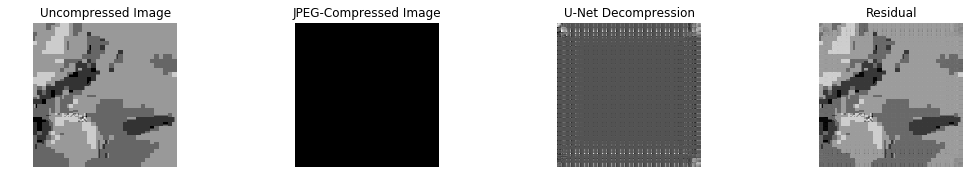

In [76]:
ii = 3615
print(np.min(test_unc[ii,:,:,0]),np.max(test_unc[ii,:,:,0]))
print(np.min(img_pred[ii,:,:,0]),np.max(img_pred[ii,:,:,0]))

plt.figure(figsize=(18,9))
plt.subplot(3,4,1)
plt.imshow(test_unc[ii,:,:,0],cmap = "gray")
plt.axis("off")
plt.title("Uncompressed Image")
plt.subplot(3,4,2)
plt.imshow(test_compr[ii,:,:,0],cmap = "gray")
plt.axis("off")
plt.title("JPEG-Compressed Image")
plt.subplot(3,4,3)
plt.imshow(img_pred[ii,:,:,0],cmap = "gray")
plt.axis("off")
plt.title("U-Net Decompression")
plt.subplot(3,4,4)
plt.imshow(test_unc[ii,:,:,0] - img_pred[ii,:,:,0],cmap = "gray")
plt.axis("off")
plt.title("Residual")
plt.show()    

In [75]:
print(test_images[3615])
# im1 = Image.open(test_images[2779])
# test_unc[2779,:,:,0] = np.array(im1, dtype=np.float32)

../../Gray/ILSVRC2012_val_00049262.tif


In [81]:
pred = np.delete(pred,[3615],axis=0)


In [79]:
print(test_unc.shape)

(3624, 256, 256, 1)
